In [22]:
import torch as pt
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, classification_report

# Pre-Procesing Data

UDP CSV from https://www.kaggle.com/datasets/jacobvs/ddos-attack-network-logs/data

In this Cell we convert our csv records into a pandas dataframe.

The sampled variable takes 200,000 records from our df randomly. This is because our csv contains over 1,000,000 records and we consider that is way too much specially when taking into consideration the other data for different DDoS attacks.

Also we are turning string columns into a numerical values

In [24]:
df = pd.read_csv('/content/DDoS_data_with_flags.csv')
df.head()


,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_RATE,BYTE_RATE,PKT_AVG_SIZE,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS
0,249,204,4153,13,48,cbr,755,-------,6001,35114,...,780.157677,7065.655787,279.482700,0.841595,1.215298,104.480675,355.000893,374.967482,146.170693,UDP-FLOOD
1,202,115,2743,40,16,cbr,93,-------,9867,91454,...,1368.421355,9538.124986,1074.962164,0.737195,1.562301,18.803125,932.317468,363.120956,3.957852,UDP-FLOOD
2,77,225,3838,44,49,tcp,1180,---S-A-,2179,44829,...,584.640856,5839.892912,244.041675,0.673866,0.601061,757.089636,183.717752,918.434328,684.272869,HTTP-FLOOD
3,226,42,7680,33,2,tcp,398,---A---,8705,14967,...,1136.745813,8827.138625,295.806950,0.980193,2.224947,248.128768,506.958555,233.350247,286.716721,TCP-FLOOD
4,121,243,8552,35,3,tcp,583,---S---,6635,5447,...,1415.925289,7024.088311,390.001964,0.709018,2.964156,237.732569,637.796930,12.013045,51.293013,TCP-FLOOD


In [25]:
le = LabelEncoder()
le.fit(df['PKT_CLASS'])

# Create a mapping from the encoded values to the original labels
pkt_class_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# Display the mapping
print("PKT_CLASS label encoding:")
for encoded_value, original_label in pkt_class_mapping.items():
    print(f'{encoded_value}: {original_label}')

# Now apply the transformation (after displaying the original labels)
df['PKT_CLASS'] = le.transform(df['PKT_CLASS'])

PKT_CLASS label encoding:
0: HTTP-FLOOD
1: Normal
2: SYN-FLOOD
3: Smurf
4: TCP-FLOOD
5: UDP-FLOOD


In [26]:
le = LabelEncoder()
# df = df.drop(columns=['FLAGS', "FID", "SEQ_NUMBER"])
df['PKT_TYPE'] = le.fit_transform(df['PKT_TYPE'])
df['FLAGS'] = le.fit_transform(df['FLAGS'])
df['NODE_NAME_FROM'] = le.fit_transform(df['NODE_NAME_FROM'])
df['NODE_NAME_TO'] = le.fit_transform(df['NODE_NAME_TO'])
df['PKT_CLASS'] = le.fit_transform(df['PKT_CLASS'])
df['session_duration'] = abs(df['LAST_PKT_RESEVED'] - df['FIRST_PKT_SENT'])
df['request_time'] = abs(df['PKT_RESEVED_TIME'] - df['PKT_SEND_TIME'])
df['ttl'] = df['session_duration'] - 64
df['request_rate'] = df['NUMBER_OF_PKT'] / df['session_duration']
# df = df.dropna(subset=['PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_AVG_SIZE', 'UTILIZATION', 'PKT_DELAY', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME', 'FIRST_PKT_SENT', 'LAST_PKT_RESEVED'])
sampled = df.sample(n=200000, random_state=42)
sampled.head()


,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,PKT_CLASS,session_duration,request_time,ttl,request_rate
183139,197,133,2085,14,49,0,1045,1,8171,28631,...,2.504465,959.745948,288.635944,611.801715,163.186464,1,448.615251,671.110004,384.615251,0.176097
49679,201,101,8288,7,6,3,985,3,9195,83671,...,4.738034,53.751092,147.258405,700.252847,40.658284,2,659.594562,93.507313,595.594562,1.651014
1032097,128,118,2041,18,49,3,729,4,6318,11080,...,0.598507,383.196619,378.272984,461.287171,943.299718,0,482.012548,4.923635,418.012548,2.012396
222898,94,29,9047,18,37,3,307,0,5837,48484,...,3.310050,971.993317,769.382932,858.027527,94.611324,1,763.416203,202.610385,699.416203,0.095623
349757,95,133,690,18,2,3,797,3,6442,36086,...,2.550347,794.812623,829.425816,372.036222,722.209243,4,350.173021,34.613193,286.173021,2.978528


# Data Splitting

Spliting the data into 70, 15, 15 porcentage for training, testing and validation.

In [35]:
Y = sampled['PKT_CLASS']
X = sampled.drop(columns='PKT_CLASS')

# First Splitting Data into 70% training and 30% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# Second splitting 50% testing and 50% validation
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")

X_test.head()


Training set size: 140000
Testing set size: 30000
Validation set size: 30000


,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,session_duration,request_time,ttl,request_rate
526131,65,17,8772,26,22,3,1072,1,5912,82382,...,0.592344,4.385495,623.434164,507.589027,811.636120,950.509718,138.873597,115.845137,74.873597,0.475252
861653,141,211,5010,44,13,3,881,3,8967,38235,...,0.763557,2.909818,656.399063,821.984421,189.215748,431.556535,242.340787,165.585358,178.340787,5.698587
285451,87,126,299,37,17,2,135,0,5845,30440,...,0.769588,2.761851,67.981182,955.344448,503.753402,245.497616,258.255785,887.363266,194.255785,5.672671
211139,103,29,5213,44,23,0,391,1,8697,65584,...,0.271283,1.860629,103.554773,747.429487,356.544301,820.029690,463.485390,643.874715,399.485390,0.120824
1088754,151,12,9053,12,44,3,1230,3,5380,50890,...,0.860749,2.653340,558.018771,949.265815,643.766487,711.017831,67.251345,391.247043,3.251345,16.386289


# Standarization

Standarization will help us clean our dataset allowing us to set mean of 0 and a standard deviation of 1 of our features. Since most of our features are numerical values we can make features with different units or scales contribute equally to the models learning process.

In [34]:
# Applying Standarization
# scaler = StandardScaler()
# X_scaled_train = scaler.fit_transform(X_train)
# X_scaled_test = scaler.transform(X_test)
# X_scaled_val = scaler.transform(X_val)

# # Turining back into df, to make data easier to manipulate
# X_train = pd.DataFrame(X_scaled_train, columns=X_train.columns)
# X_test = pd.DataFrame(X_scaled_test, columns=X_test.columns)
# X_val = pd.DataFrame(X_scaled_val, columns=X_val.columns)



,SRC_ADD,DES_ADD,PKT_ID,FROM_NODE,TO_NODE,PKT_TYPE,PKT_SIZE,FLAGS,FID,SEQ_NUMBER,...,UTILIZATION,PKT_DELAY,PKT_SEND_TIME,PKT_RESEVED_TIME,FIRST_PKT_SENT,LAST_PKT_RESEVED,session_duration,request_time,ttl,request_rate
0,-0.474559,-0.463535,-0.349759,-1.480370,1.129181,0.846483,0.802390,-0.035191,0.519404,-1.472009,...,-1.257113,-1.367779,1.518959,-1.442044,-1.374647,-1.403518,-1.391450,2.216400,-1.391450,-0.010530
1,-0.365645,0.749934,0.485811,1.273176,0.068747,0.846483,-1.099772,1.573273,-1.347036,-0.900028,...,1.141430,0.268080,-0.981608,-0.388010,1.543909,0.544595,-0.201076,-0.685670,-0.201076,-0.009004
2,0.614587,1.240776,-0.012005,-0.350710,-0.426121,-0.697872,-1.230220,-0.839423,0.078630,0.671610,...,1.106807,-0.655483,-0.603515,1.098548,1.382606,0.053773,0.201372,0.676433,0.201372,-0.010537
3,-0.583474,-0.558977,-0.401269,-1.127351,-1.203773,0.074306,-0.502085,-0.839423,0.957403,1.520133,...,0.370865,1.475418,-1.595238,0.651505,-1.228281,-0.702956,-0.756564,1.343478,-0.756564,-0.005803
4,-1.236962,1.377120,0.365506,1.131968,1.553354,0.846483,0.249767,-0.035191,0.274915,0.339350,...,-0.335861,0.603537,0.643601,-0.844069,0.266403,0.390059,-1.249698,0.408595,-1.249698,-0.012670


# Correlation
Deploying a correlation Matrix to visualize how features might correalate

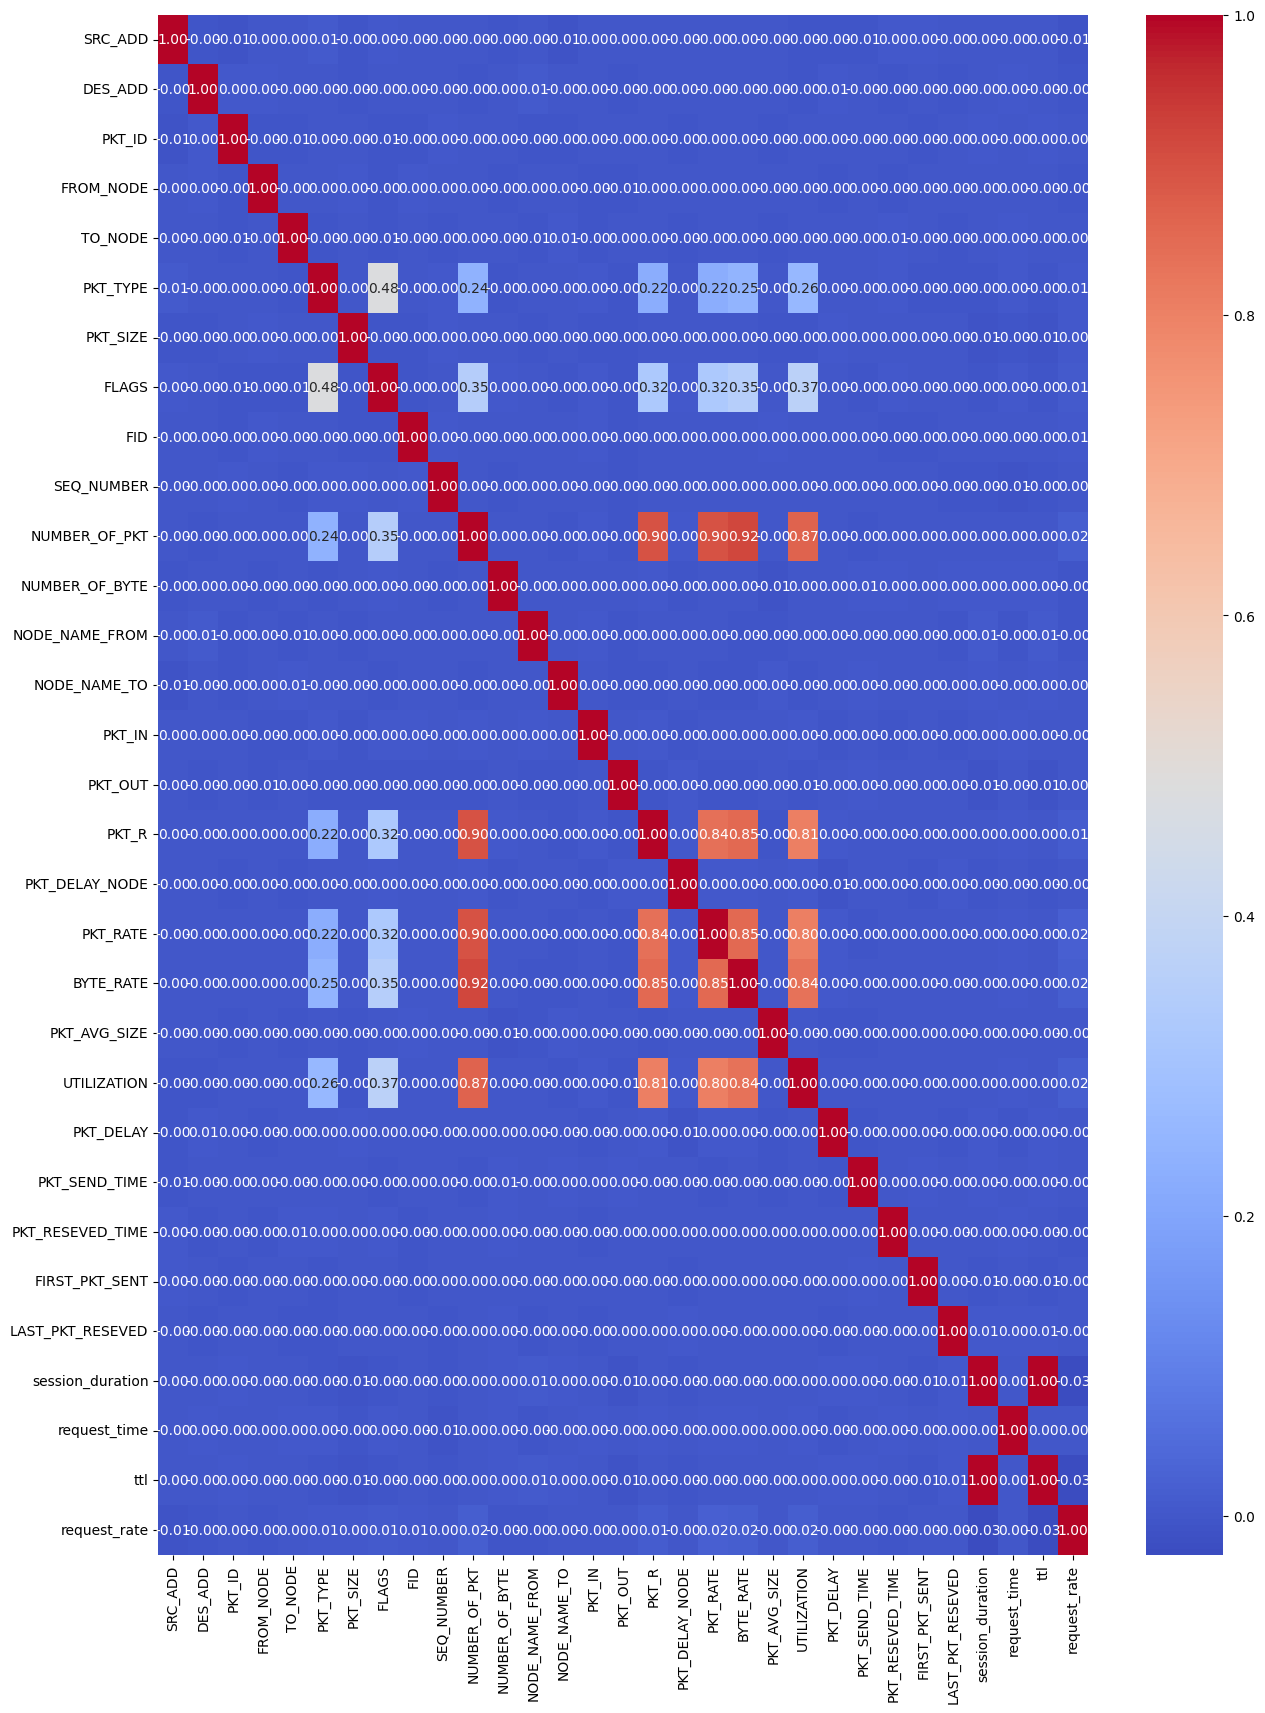

In [36]:
corr_matrix = X_train.corr()
plt.figure(figsize=(15, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

# Results
From this corr matrix we can see red points strong correlation between features. We can see request rate and ttl have a strong relationship, and many more.


# Feature Selection

In [37]:
columns_to_drop = ["NUMBER_OF_BYTE", "BYTE_RATE", "SRC_ADD", "DES_ADD", "PKT_ID", "FROM_NODE", "TO_NODE", "PKT_SIZE", "FID", "SEQ_NUMBER", "NODE_NAME_FROM", "NODE_NAME_TO", "PKT_IN", "PKT_OUT", "PKT_DELAY_NODE", "PKT_AVG_SIZE", "PKT_SEND_TIME", "PKT_RESEVED_TIME", "FIRST_PKT_SENT", "LAST_PKT_RESEVED", "request_time" ]
X_train =  X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)
X_val = X_val.drop(columns=columns_to_drop)

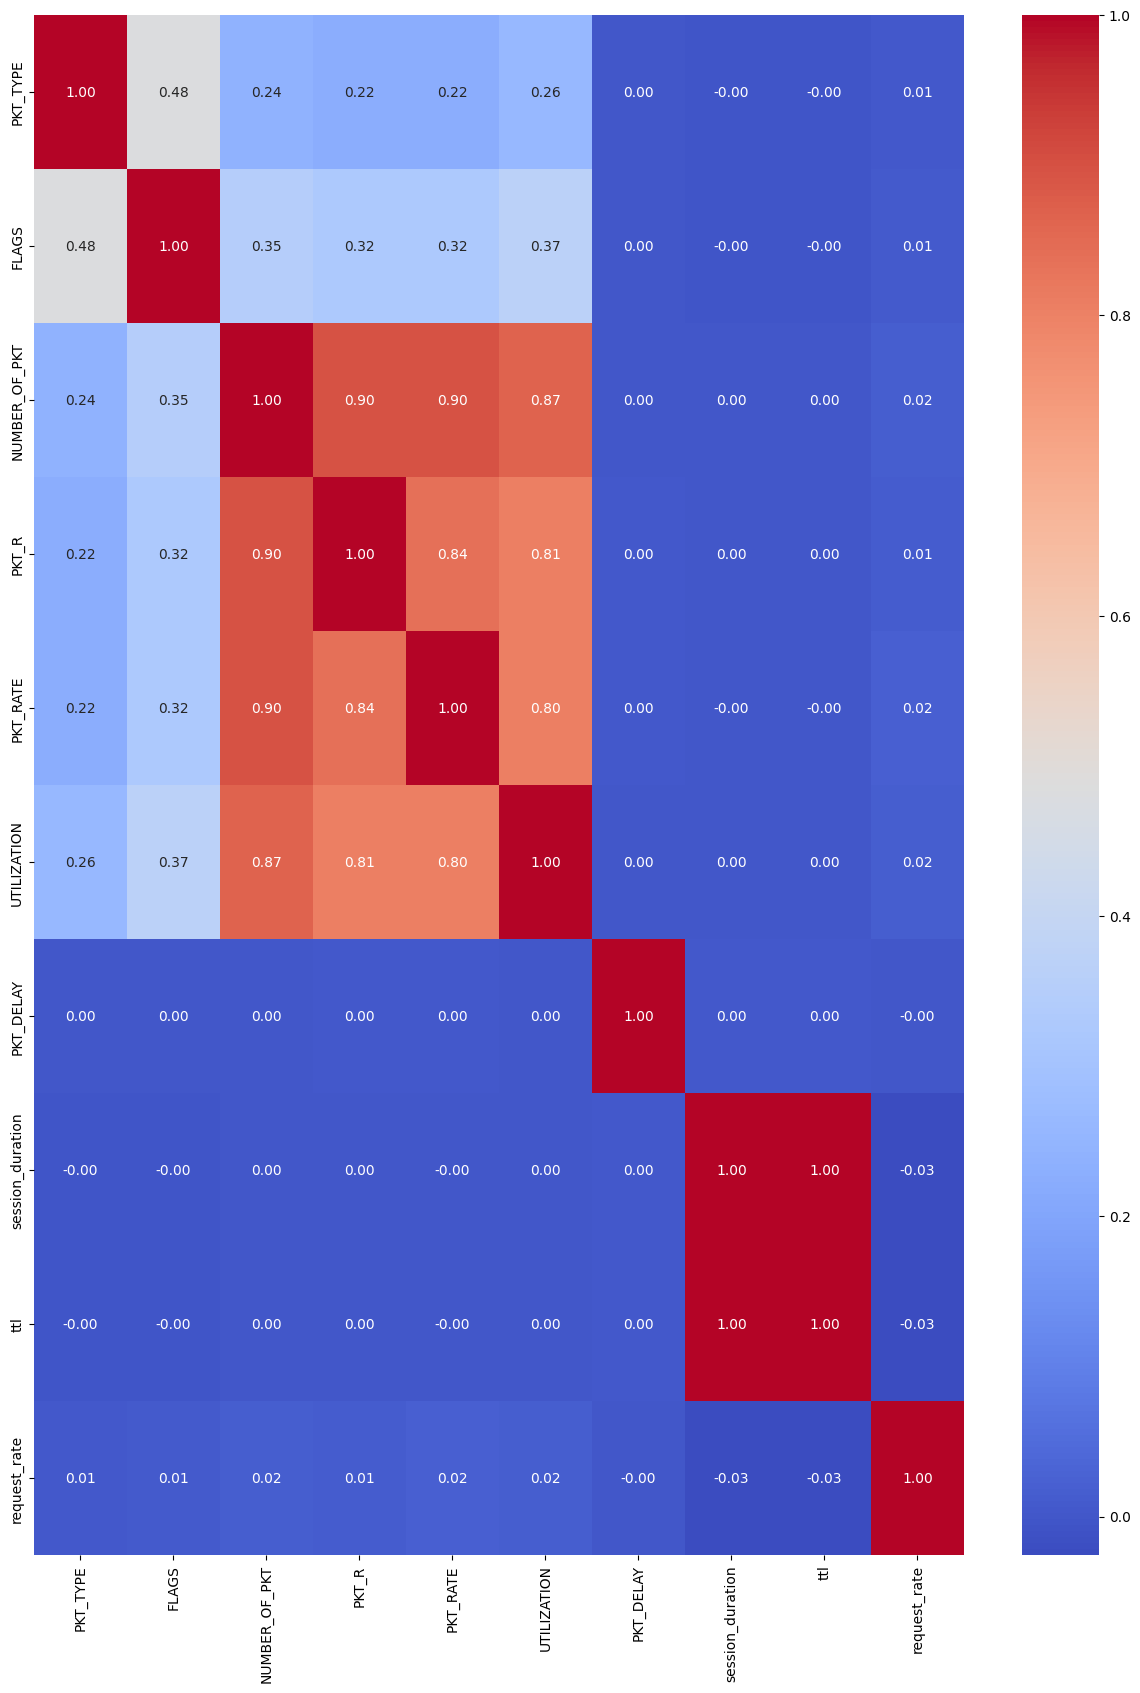

In [38]:
corr_matrix = X_train.corr()
plt.figure(figsize=(15, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.show()

# Model
Training Model

In [39]:
X_test.head()

,PKT_TYPE,FLAGS,NUMBER_OF_PKT,PKT_R,PKT_RATE,UTILIZATION,PKT_DELAY,session_duration,ttl,request_rate
526131,3,1,66,90.063476,93.689675,0.592344,4.385495,138.873597,74.873597,0.475252
861653,3,3,1381,914.280436,771.602861,0.763557,2.909818,242.340787,178.340787,5.698587
285451,2,0,1465,1455.416100,576.476132,0.769588,2.761851,258.255785,194.255785,5.672671
211139,0,1,56,84.805706,35.300220,0.271283,1.860629,463.485390,399.485390,0.120824
1088754,3,3,1102,753.815699,1446.108853,0.860749,2.653340,67.251345,3.251345,16.386289


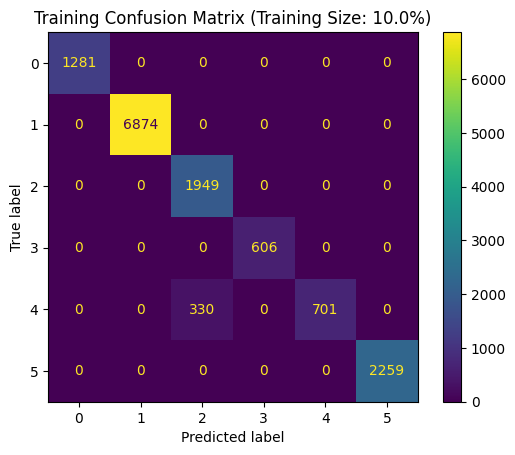

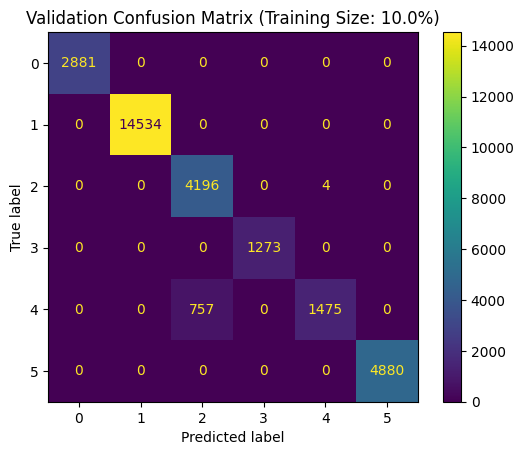

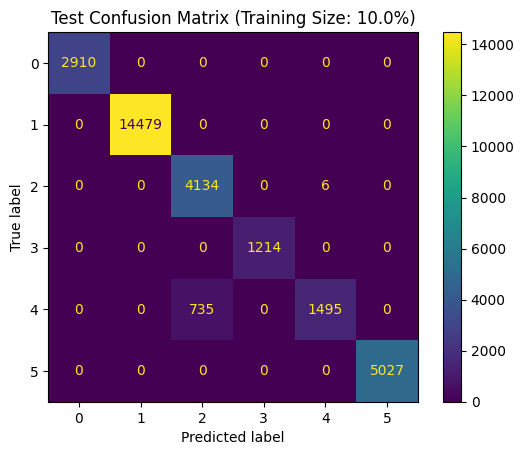

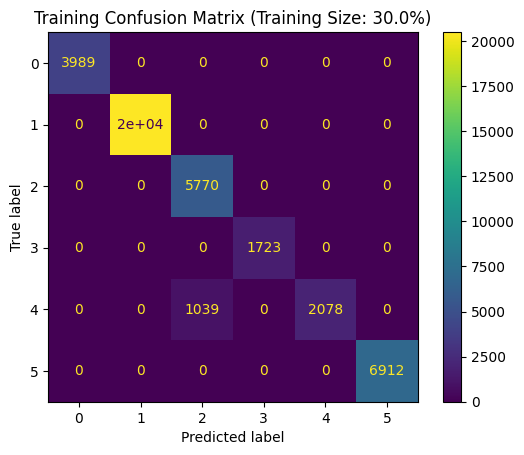

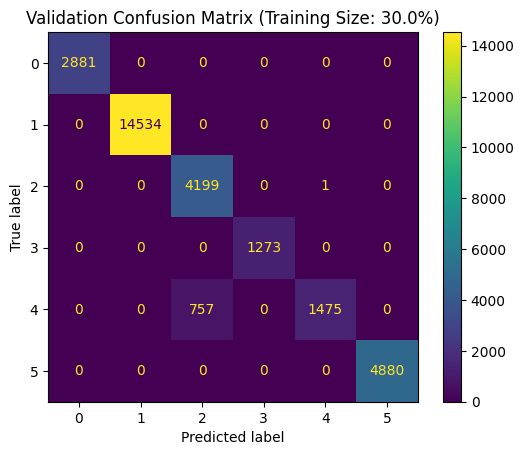

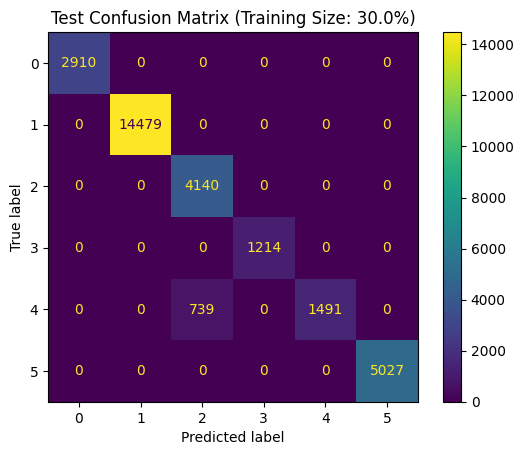

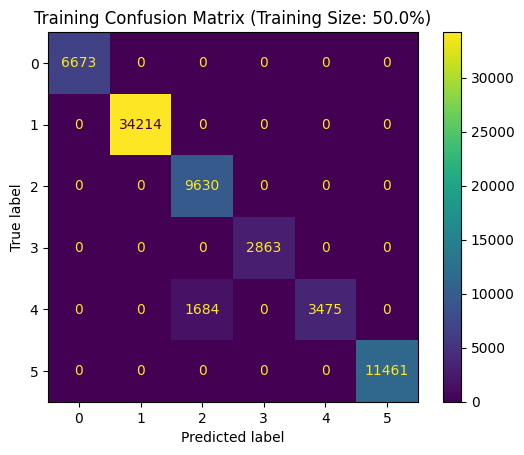

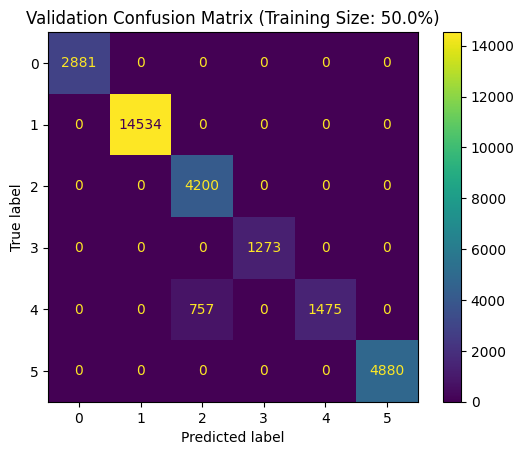

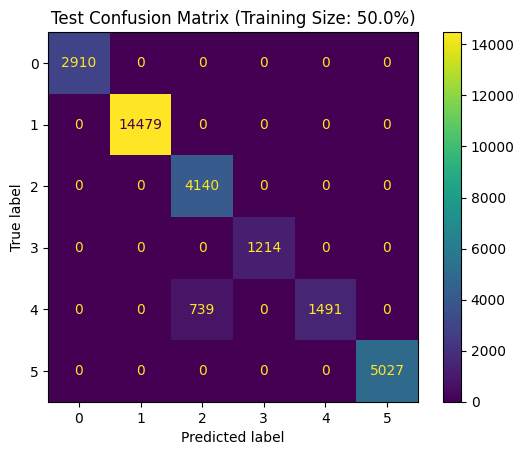

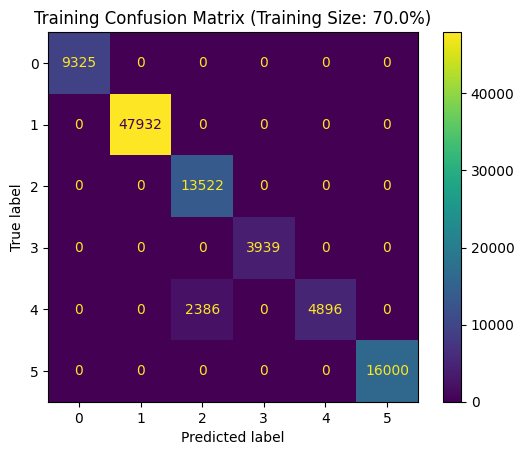

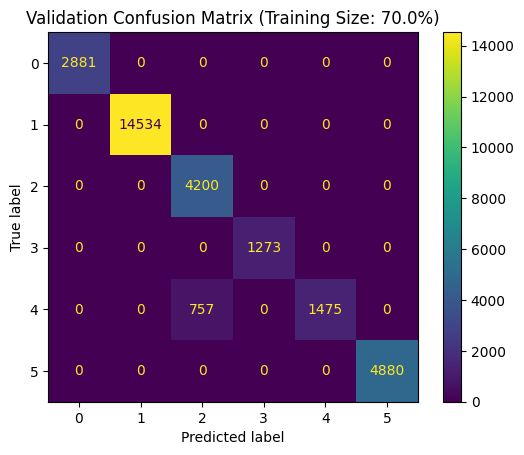

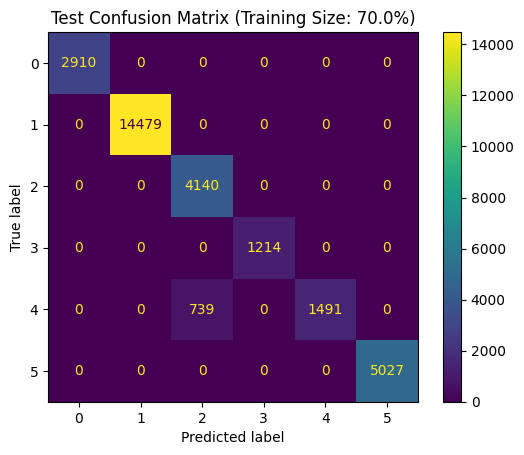

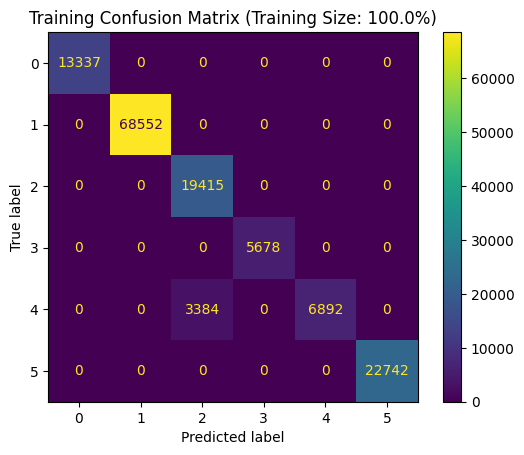

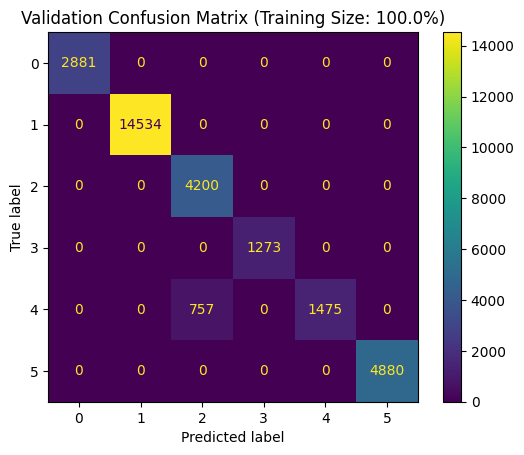

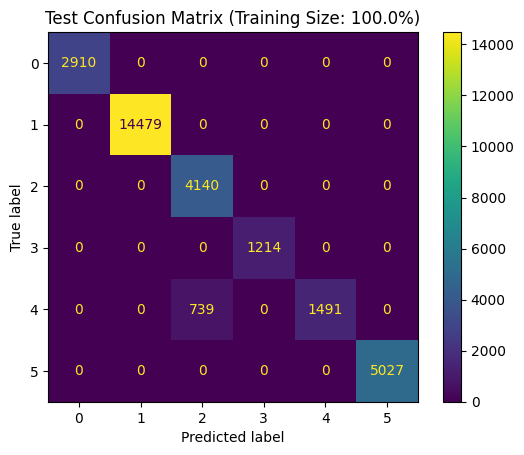

In [46]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
train_scores = []
validation_scores = []
test_scores = []
X_test_with_predictions = pd.DataFrame()

y_test_report = None
for size in train_sizes:
    # Subsampling data, to get interval values for plotting values
    X_train_sample = X_train[:int(size * len(X_train))]
    y_train_sample = Y_train[:int(size * len(Y_train))]

    # Training the model
    model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    model.fit(X_train_sample, y_train_sample)

    Y_train_acc = model.predict(X_train_sample)
    Y_val_acc = model.predict(X_val)
    Y_test_acc = model.predict(X_test)

    train_acc = accuracy_score(y_train_sample, Y_train_acc)
    train_scores.append(train_acc)
    val_acc = accuracy_score(Y_val, Y_val_acc)
    validation_scores.append(val_acc)
    test_acc = accuracy_score(Y_test, Y_test_acc)
    test_scores.append(test_acc)

    train_cm = confusion_matrix(y_train_sample, Y_train_acc)
    val_cm = confusion_matrix(Y_val, Y_val_acc)
    test_cm = confusion_matrix(Y_test, Y_test_acc)

    disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
    disp.plot()
    plt.title(f'Training Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()


    disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
    disp.plot()
    plt.title(f'Validation Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
    disp.plot()
    plt.title(f'Test Confusion Matrix (Training Size: {size * 100}%)')
    plt.show()




    X_test_temp = X_test.copy()
    X_test_temp['predicted'] = Y_test_acc


    X_test_with_predictions = pd.concat([X_test_with_predictions, X_test_temp], ignore_index=True)



    # Display or store combined data (X_test with predictions)
    # print(X_test_with_predictions.head())  # Display first 5 rows


In [47]:
print(X_test_with_predictions.head())

   PKT_TYPE  FLAGS  NUMBER_OF_PKT        PKT_R     PKT_RATE  UTILIZATION  \
0         3      1             66    90.063476    93.689675     0.592344   
1         3      3           1381   914.280436   771.602861     0.763557   
2         2      0           1465  1455.416100   576.476132     0.769588   
3         0      1             56    84.805706    35.300220     0.271283   
4         3      3           1102   753.815699  1446.108853     0.860749   

   PKT_DELAY  session_duration         ttl  request_rate  predicted  
0   4.385495        138.873597   74.873597      0.475252          1  
1   2.909818        242.340787  178.340787      5.698587          2  
2   2.761851        258.255785  194.255785      5.672671          3  
3   1.860629        463.485390  399.485390      0.120824          1  
4   2.653340         67.251345    3.251345     16.386289          2  


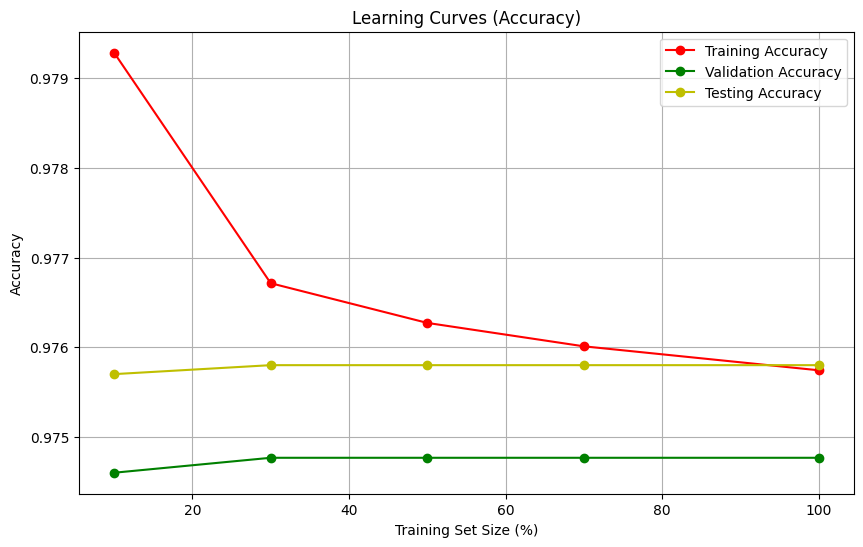

In [14]:

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(np.array(train_sizes) * 100, train_scores, 'o-', color="r", label="Training Accuracy")
plt.plot(np.array(train_sizes) * 100, validation_scores, 'o-', color="g", label="Validation Accuracy")
plt.plot(np.array(train_sizes) * 100, test_scores, 'o-', color="y", label="Testing Accuracy")
plt.title('Learning Curves (Accuracy)')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid()
plt.show()

# # Loss Curves
# plt.figure(figsize=(10, 6))
# plt.plot(np.array(train_sizes) * 100, train_losses, 'o-', color="r", label="Training Loss")
# plt.plot(np.array(train_sizes) * 100, validation_losses, 'o-', color="g", label="Validation Loss")
# plt.plot(np.array(train_sizes) * 100, test_losses, 'o-', color="y", label="Testing Loss")
# plt.title('Learning Curves (Loss)')
# plt.xlabel('Training Set Size (%)')
# plt.ylabel('MSE')
# plt.legend(loc="best")
# plt.grid()
# plt.show()